#  TEMPORAL ÖZELLİKLER:

##  AMAÇ:
Mevcut 100 tile verisine **temporal (zaman serisi) özellikler** ekleyerek accuracy'yi artırma

## ✨ YENİ ÖZELLİKLER:
```
Mevcut: 22 özellik (statik istatistikler)
- B2_mean, B2_std, B2_min, B2_max, B2_median
- B3_mean, ...
- NDVI, EVI

Yeni: +15 temporal özellik
- NDVI_trend (eğim)
- NDVI_peak_time (maksimum zamanı)
- NDVI_peak_value (maksimum değer)
- NDVI_range (max - min)
- NDVI_cv (coefficient of variation)
- NDVI_growing_season (büyüme sezonu uzunluğu)
- NDVI_greenup_rate (yeşillenme hızı)
- NDVI_senescence_rate (solma hızı)
- NDVI_max_increase (max artış)
- NDVI_max_decrease (max azalış)
- NDVI_seasonal_amplitude (mevsimsel genlik)
- Monthly means (aylık ortalamalar)

TOPLAM: 37 özellik
```


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

BASE_DIR = Path("/content/drive/MyDrive/SA_CropType_SourceCoop")
TRAIN_DIR = BASE_DIR / "train"
LABELS_DIR = TRAIN_DIR / "labels"
S2_DIR = TRAIN_DIR / "imagery" / "s2"
OUT_DIR = BASE_DIR / "outputs"
META_DIR = OUT_DIR / "meta"
FIG_DIR = OUT_DIR / "figures"
TAB_DIR = OUT_DIR / "tables"

for d in [OUT_DIR, META_DIR, FIG_DIR, TAB_DIR]:
    d.mkdir(parents=True, exist_ok=True)

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix
)

!pip install xgboost -q
import xgboost as xgb
import time
from datetime import datetime
import json

print("✅ Kurulum tamam!")
print(f"⏰ Başlangıç: {datetime.now().strftime('%H:%M:%S')}")

✅ Kurulum tamam!
⏰ Başlangıç: 17:44:07


##  VERİ YÜKLEME

In [ ]:
# 100 tile seçimini yükle
tfc_selected = pd.read_csv(META_DIR / "tfc_selected_top100.csv")

TARGET_CROPS = [
    "Wine grapes",
    "Wheat",
    "Planted pastures (perennial)",
    "Lucerne/Medics"
]

print(f"📊 Veri özeti:")
print(f"  Toplam kayıt: {len(tfc_selected):,}")
print(f"  Tile sayısı: {tfc_selected['tile_id'].nunique()}")
print(f"\n🌾 Sınıf dağılımı:")
for crop in TARGET_CROPS:
    count = len(tfc_selected[tfc_selected['crop'] == crop])
    print(f"  {crop:30s}: {count:5,}")

📊 Veri özeti:
  Toplam kayıt: 8,228
  Tile sayısı: 100

🌾 Sınıf dağılımı:
  Wine grapes                   : 4,809
  Wheat                         : 1,050
  Planted pastures (perennial)  : 1,326
  Lucerne/Medics                : 1,043


##  TEMPORAL ÖZELLİK ÇIKARIMI

In [ ]:
def smart_date_selection(tile_dir, max_dates=15):
    """Akıllı tarih seçimi (aylara dağıtılmış)"""
    all_dates = sorted([d for d in tile_dir.iterdir() if d.is_dir()])
    if len(all_dates) == 0:
        return [], {}

    date_info = []
    for date_folder in all_dates:
        try:
            parts = date_folder.name.split('_')
            if len(parts) >= 3:
                year = int(parts[0])
                month = int(parts[1])
                day = int(parts[2])
                date_info.append({
                    'path': date_folder,
                    'year_month': f"{year}_{month:02d}",
                    'date_num': year * 10000 + month * 100 + day
                })
        except:
            continue

    if len(date_info) == 0:
        return all_dates[:max_dates], {}

    df = pd.DataFrame(date_info)
    monthly_counts = df.groupby('year_month').size()
    n_months = len(monthly_counts)
    dates_per_month = max(1, max_dates // n_months)

    selected_dates = []
    for year_month, group in df.groupby('year_month'):
        n_select = min(dates_per_month, len(group))
        if len(group) > n_select:
            indices = np.linspace(0, len(group)-1, n_select, dtype=int)
            selected = group.iloc[indices]
        else:
            selected = group
        selected_dates.extend(selected.to_dict('records'))

    if len(selected_dates) < max_dates:
        remaining = max_dates - len(selected_dates)
        for year_month in monthly_counts.nlargest(remaining).index:
            group = df[df['year_month'] == year_month]
            group_dicts = group.to_dict('records')
            unselected = [d for d in group_dicts if d not in selected_dates]
            if unselected:
                selected_dates.append(unselected[0])
                if len(selected_dates) >= max_dates:
                    break

    selected_dates = sorted(selected_dates, key=lambda x: x['date_num'])[:max_dates]
    paths = [d['path'] for d in selected_dates]
    distribution = pd.DataFrame(selected_dates).groupby('year_month').size().to_dict()

    return paths, distribution, selected_dates


def extract_features_with_temporal(tile_id, field_id, s2_dir, labels_dir, num_dates=15):
    """
    TEMPORAL ÖZELLİKLER ile özellik çıkarımı

    Returns:
    --------
    dict: Hem statik hem de temporal özellikler
    """
    features = {}

    try:
        # Label mask
        label_path = labels_dir / f"{tile_id}_field_ids.tif"
        if not label_path.exists():
            return None

        with rasterio.open(label_path) as src:
            label_mask = src.read(1)

        field_mask = (label_mask == field_id)
        if field_mask.sum() == 0:
            return None

        # Tile dizini
        tile_dir = s2_dir / str(tile_id)
        if not tile_dir.exists():
            return None

        # Tarih seçimi
        date_folders, distribution, date_info = smart_date_selection(tile_dir, max_dates=num_dates)
        if len(date_folders) < 3:  # En az 3 tarih gerekli
            return None

        # =============================================================
        # BANT DEĞERLERİ + ZAMAN SERİSİ
        # =============================================================
        band_map = {'B2': 'B02', 'B3': 'B03', 'B4': 'B04', 'B8': 'B08'}
        band_values = {name: [] for name in band_map.keys()}

        # Temporal: Her tarih için NDVI
        ndvi_timeseries = []
        valid_dates = []

        for i, date_folder in enumerate(date_folders):
            date_str = date_folder.name

            # Bantları oku
            date_bands = {}
            for band_short, band_full in band_map.items():
                band_file = date_folder / f"{tile_id}_{date_str}_{band_full}_10m.tif"
                if band_file.exists():
                    with rasterio.open(band_file) as src:
                        band_data = src.read(1)
                    field_vals = band_data[field_mask]
                    field_vals = field_vals[field_vals > 0]

                    if len(field_vals) > field_mask.sum() * 0.3:
                        date_bands[band_short] = field_vals
                        band_values[band_short].extend(field_vals.tolist())

            # NDVI hesapla (bu tarih için)
            if 'B8' in date_bands and 'B4' in date_bands:
                nir = np.mean(date_bands['B8'])
                red = np.mean(date_bands['B4'])
                if (nir + red) > 0:
                    ndvi = (nir - red) / (nir + red)
                    ndvi_timeseries.append(ndvi)
                    valid_dates.append(i)

        # Yeterli veri var mı?
        if len(ndvi_timeseries) < 3:
            return None

        # =============================================================
        # STATİK ÖZELLİKLER (Önceki gibi)
        # =============================================================
        for band, vals in band_values.items():
            if len(vals) > 0:
                features[f'{band}_mean'] = np.mean(vals)
                features[f'{band}_std'] = np.std(vals)
                features[f'{band}_min'] = np.min(vals)
                features[f'{band}_max'] = np.max(vals)
                features[f'{band}_median'] = np.median(vals)
            else:
                return None

        # NDVI (genel)
        features['NDVI_mean'] = np.mean(ndvi_timeseries)
        features['NDVI_std'] = np.std(ndvi_timeseries)

        # EVI (genel)
        if all(k in features for k in ['B8_mean', 'B4_mean', 'B2_mean']):
            nir = features['B8_mean']
            red = features['B4_mean']
            blue = features['B2_mean']
            denom = nir + 6*red - 7.5*blue + 1
            features['EVI'] = 2.5 * (nir - red) / denom if denom != 0 else 0

        # =============================================================
        # TEMPORAL ÖZELLİKLER (YENİ!)
        # =============================================================
        ndvi_ts = np.array(ndvi_timeseries)
        n_obs = len(ndvi_ts)

        # 1. TREND (Eğim)
        if n_obs > 1:
            x = np.arange(n_obs)
            slope, intercept = np.polyfit(x, ndvi_ts, 1)
            features['NDVI_trend'] = slope
            features['NDVI_intercept'] = intercept
        else:
            features['NDVI_trend'] = 0
            features['NDVI_intercept'] = ndvi_ts[0]

        # 2. PEAK TIME & VALUE
        peak_idx = np.argmax(ndvi_ts)
        features['NDVI_peak_time'] = peak_idx / n_obs  # Normalize [0,1]
        features['NDVI_peak_value'] = np.max(ndvi_ts)

        # 3. RANGE
        features['NDVI_range'] = np.max(ndvi_ts) - np.min(ndvi_ts)
        features['NDVI_min'] = np.min(ndvi_ts)
        features['NDVI_max'] = np.max(ndvi_ts)

        # 4. COEFFICIENT OF VARIATION
        if features['NDVI_mean'] != 0:
            features['NDVI_cv'] = features['NDVI_std'] / features['NDVI_mean']
        else:
            features['NDVI_cv'] = 0

        # 5. GROWING SEASON LENGTH (NDVI > threshold)
        threshold = features['NDVI_mean']
        growing_season = np.sum(ndvi_ts > threshold)
        features['NDVI_growing_season'] = growing_season / n_obs

        # 6. GREENUP & SENESCENCE RATES
        if n_obs > 2:
            diff = np.diff(ndvi_ts)
            features['NDVI_max_increase'] = np.max(diff) if len(diff) > 0 else 0
            features['NDVI_max_decrease'] = np.min(diff) if len(diff) > 0 else 0
            features['NDVI_mean_change'] = np.mean(np.abs(diff)) if len(diff) > 0 else 0

            # Greenup rate (first half increase)
            mid = n_obs // 2
            if mid > 0:
                greenup = ndvi_ts[mid] - ndvi_ts[0]
                features['NDVI_greenup_rate'] = greenup / mid

                # Senescence rate (second half decrease)
                senescence = ndvi_ts[-1] - ndvi_ts[mid]
                features['NDVI_senescence_rate'] = senescence / (n_obs - mid)
            else:
                features['NDVI_greenup_rate'] = 0
                features['NDVI_senescence_rate'] = 0
        else:
            features['NDVI_max_increase'] = 0
            features['NDVI_max_decrease'] = 0
            features['NDVI_mean_change'] = 0
            features['NDVI_greenup_rate'] = 0
            features['NDVI_senescence_rate'] = 0

        # 7. SEASONAL AMPLITUDE
        features['NDVI_amplitude'] = features['NDVI_max'] - features['NDVI_min']

        return features

    except Exception as e:
        return None

print("✅ Temporal özellik fonksiyonu hazır!")
print("   Statik: 22 özellik")
print("   Temporal: 15 özellik")
print("   TOPLAM: 37 özellik")

✅ Temporal özellik fonksiyonu hazır!
   Statik: 22 özellik
   Temporal: 15 özellik
   TOPLAM: 37 özellik


##  ÖZELLİK ÇIKARIMI (TEMPORAL)

In [ ]:
print(f"🚀 TEMPORAL özellik çıkarımı başlıyor...")
print(f"📊 İşlenecek: {len(tfc_selected):,} kayıt")
print(f"⏱️  Tahmini süre: ~{len(tfc_selected)//100} dakika")
print(f"⏰ Başlangıç: {datetime.now().strftime('%H:%M:%S')}")
print(f"⏰ Tahmini bitiş: {(datetime.now() + pd.Timedelta(minutes=len(tfc_selected)//100)).strftime('%H:%M:%S')}\n")

features_list = []
labels_list = []
failed = 0

# İlerleme takibi
checkpoint_interval = 1000
last_checkpoint = 0

for idx, row in tqdm(tfc_selected.iterrows(), total=len(tfc_selected), desc="Temporal Çıkarım"):
    tile_id = row['tile_id']
    field_id = row['field_id']
    crop = row['crop']

    features = extract_features_with_temporal(tile_id, field_id, S2_DIR, LABELS_DIR, num_dates=15)

    if features and len(features) > 0:
        features_list.append(features)
        labels_list.append(crop)
    else:
        failed += 1

    # Checkpoint
    if len(features_list) - last_checkpoint >= checkpoint_interval:
        last_checkpoint = len(features_list)
        print(f"\n📊 Checkpoint: {len(features_list):,} başarılı, {failed} başarısız")
        print(f"   Başarı oranı: {len(features_list)/(len(features_list)+failed)*100:.1f}%")

        # İlk başarılı örneğin özellik sayısını göster
        if len(features_list) == checkpoint_interval:
            print(f"   Özellik sayısı: {len(features_list[0])}")
            temp_keys = list(features_list[0].keys())
            print(f"   İlk 5 özellik: {temp_keys[:5]}")
            print(f"   Son 5 özellik: {temp_keys[-5:]}")

print(f"\n✅ Tamamlandı!")
print(f"⏰ Bitiş: {datetime.now().strftime('%H:%M:%S')}")
print(f"  Başarılı: {len(features_list):,}")
print(f"  Başarısız: {failed}")
print(f"  Başarı oranı: {len(features_list)/(len(features_list)+failed)*100:.1f}%")

🚀 TEMPORAL özellik çıkarımı başlıyor...
📊 İşlenecek: 8,228 kayıt
⏱️  Tahmini süre: ~82 dakika
⏰ Başlangıç: 17:44:17
⏰ Tahmini bitiş: 19:06:17



Temporal Çıkarım:  12%|█▏        | 1000/8228 [14:45<1:16:14,  1.58it/s]


📊 Checkpoint: 1,000 başarılı, 0 başarısız
   Başarı oranı: 100.0%
   Özellik sayısı: 38
   İlk 5 özellik: ['B2_mean', 'B2_std', 'B2_min', 'B2_max', 'B2_median']
   Son 5 özellik: ['NDVI_max_decrease', 'NDVI_mean_change', 'NDVI_greenup_rate', 'NDVI_senescence_rate', 'NDVI_amplitude']


Temporal Çıkarım:  24%|██▍       | 2000/8228 [27:55<1:04:41,  1.60it/s]


📊 Checkpoint: 2,000 başarılı, 0 başarısız
   Başarı oranı: 100.0%


Temporal Çıkarım:  36%|███▋      | 3000/8228 [42:07<1:05:49,  1.32it/s]


📊 Checkpoint: 3,000 başarılı, 0 başarısız
   Başarı oranı: 100.0%


Temporal Çıkarım:  49%|████▊     | 4000/8228 [56:16<46:57,  1.50it/s]


📊 Checkpoint: 4,000 başarılı, 0 başarısız
   Başarı oranı: 100.0%


Temporal Çıkarım:  61%|██████    | 5000/8228 [1:08:40<34:05,  1.58it/s]


📊 Checkpoint: 5,000 başarılı, 0 başarısız
   Başarı oranı: 100.0%


Temporal Çıkarım:  73%|███████▎  | 6000/8228 [1:21:15<24:20,  1.53it/s]


📊 Checkpoint: 6,000 başarılı, 0 başarısız
   Başarı oranı: 100.0%


Temporal Çıkarım:  85%|████████▌ | 7000/8228 [1:35:51<19:30,  1.05it/s]


📊 Checkpoint: 7,000 başarılı, 0 başarısız
   Başarı oranı: 100.0%


Temporal Çıkarım:  97%|█████████▋| 8000/8228 [1:48:30<03:20,  1.14it/s]


📊 Checkpoint: 8,000 başarılı, 0 başarısız
   Başarı oranı: 100.0%


Temporal Çıkarım: 100%|██████████| 8228/8228 [1:51:54<00:00,  1.23it/s]


✅ Tamamlandı!
⏰ Bitiş: 19:36:12
  Başarılı: 8,228
  Başarısız: 0
  Başarı oranı: 100.0%


##  VERİ HAZIRLAMA

In [ ]:
X = pd.DataFrame(features_list)
y = np.array(labels_list)

print(f"✅ TEMPORAL özelliklerle veri hazır:")
print(f"  Shape: {X.shape}")
print(f"  Özellik sayısı: {X.shape[1]}")

print(f"\n📊 Özellik Grupları:")
static_features = [c for c in X.columns if not c.startswith('NDVI_') or c in ['NDVI_mean', 'NDVI_std']]
temporal_features = [c for c in X.columns if c.startswith('NDVI_') and c not in ['NDVI_mean', 'NDVI_std']]

print(f"  Statik: {len(static_features)} özellik")
print(f"  Temporal: {len(temporal_features)} özellik")
print(f"\n  Temporal özellikler:")
for feat in temporal_features:
    print(f"    - {feat}")

print(f"\n🌾 Sınıf dağılımı:")
unique, counts = np.unique(y, return_counts=True)
for crop, count in zip(unique, counts):
    pct = count/len(y)*1007
    print(f"  {crop:30s}: {count:5,} ({pct:5.1f}%)")

imbalance = counts.max() / counts.min()
use_class_weight = imbalance > 2

# Label encoding
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"\n📊 Veri bölme:")
print(f"  Train: {X_train.shape[0]:,}")
print(f"  Test:  {X_test.shape[0]:,}")

✅ TEMPORAL özelliklerle veri hazır:
  Shape: (8228, 38)
  Özellik sayısı: 38

📊 Özellik Grupları:
  Statik: 23 özellik
  Temporal: 15 özellik

  Temporal özellikler:
    - NDVI_trend
    - NDVI_intercept
    - NDVI_peak_time
    - NDVI_peak_value
    - NDVI_range
    - NDVI_min
    - NDVI_max
    - NDVI_cv
    - NDVI_growing_season
    - NDVI_max_increase
    - NDVI_max_decrease
    - NDVI_mean_change
    - NDVI_greenup_rate
    - NDVI_senescence_rate
    - NDVI_amplitude

🌾 Sınıf dağılımı:
  Lucerne/Medics                : 1,043 (127.6%)
  Planted pastures (perennial)  : 1,326 (162.3%)
  Wheat                         : 1,050 (128.5%)
  Wine grapes                   : 4,809 (588.6%)

📊 Veri bölme:
  Train: 6,582
  Test:  1,646


##  RANDOM FOREST (TEMPORAL)

In [ ]:
print(f"🌲 Random Forest (TEMPORAL ÖZELLİKLER)...\n")

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=30,
    class_weight='balanced' if use_class_weight else None,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

start = time.time()
rf_model.fit(X_train, y_train)
rf_time = time.time() - start

y_pred_rf = rf_model.predict(X_test)
rf_acc = accuracy_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf, average='weighted')

print(f"\n✅ Tamamlandı ({rf_time:.2f}s)")
print(f"\n📊 Random Forest (TEMPORAL):")
print(f"  Accuracy:  {rf_acc:.4f}")
print(f"  F1-Score:  {rf_f1:.4f}")

# Feature importance (top 10)
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n🔝 En Önemli 10 Özellik:")
for i, row in feature_importance.head(10).iterrows():
    is_temporal = "📅" if row['feature'].startswith('NDVI_') and row['feature'] not in ['NDVI_mean', 'NDVI_std'] else "📊"
    print(f"  {i+1}. {is_temporal} {row['feature']:25s}: {row['importance']:.4f}")

🌲 Random Forest (TEMPORAL ÖZELLİKLER)...



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s



✅ Tamamlandı (11.62s)

📊 Random Forest (TEMPORAL):
  Accuracy:  0.8244
  F1-Score:  0.8147

🔝 En Önemli 10 Özellik:
  31. 📅 NDVI_cv                  : 0.0748
  24. 📅 NDVI_trend               : 0.0720
  37. 📅 NDVI_senescence_rate     : 0.0569
  36. 📅 NDVI_greenup_rate        : 0.0532
  25. 📅 NDVI_intercept           : 0.0484
  32. 📅 NDVI_growing_season      : 0.0417
  22. 📊 NDVI_std                 : 0.0374
  23. 📊 EVI                      : 0.0374
  15. 📊 B4_median                : 0.0361
  34. 📅 NDVI_max_decrease        : 0.0320


[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.2s finished


##  XGBOOST (TEMPORAL)

In [ ]:
print(f"🚀 XGBoost (TEMPORAL ÖZELLİKLER)...\n")

xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)

if use_class_weight:
    from sklearn.utils.class_weight import compute_sample_weight
    sample_weights = compute_sample_weight('balanced', y_train)
    start = time.time()
    xgb_model.fit(X_train, y_train, sample_weight=sample_weights)
else:
    start = time.time()
    xgb_model.fit(X_train, y_train)

xgb_time = time.time() - start

y_pred_xgb = xgb_model.predict(X_test)
xgb_acc = accuracy_score(y_test, y_pred_xgb)
xgb_f1 = f1_score(y_test, y_pred_xgb, average='weighted')

print(f"\n✅ Tamamlandı ({xgb_time:.2f}s)")
print(f"\n📊 XGBoost (TEMPORAL):")
print(f"  Accuracy:  {xgb_acc:.4f}")
print(f"  F1-Score:  {xgb_f1:.4f}")

🚀 XGBoost (TEMPORAL ÖZELLİKLER)...


✅ Tamamlandı (17.56s)

📊 XGBoost (TEMPORAL):
  Accuracy:  0.8402
  F1-Score:  0.8375


## 📊 KARŞILAŞTIRMA: Statik vs Temporal

In [ ]:
print("\n" + "="*80)
print("📊 KAPSAMLI KARŞILAŞTIRMA: STATİK vs TEMPORAL")
print("="*80)

# Statik sonuçlar (100 tile, 22 özellik)
static_rf = 0.76
static_xgb = 0.76

comparison = pd.DataFrame({
    'Özellikler': ['Statik (22)', 'Statik (22)', 'Temporal (37)', 'Temporal (37)'],
    'Model': ['Random Forest', 'XGBoost', 'Random Forest', 'XGBoost'],
    'Accuracy': [static_rf, static_xgb, rf_acc, xgb_acc],
    'F1-Score': [0.73, 0.75, rf_f1, xgb_f1]
})

print("\n" + comparison.to_string(index=False))

# İyileşme
print(f"\n📈 TEMPORAL ÖZELLİKLERİN ETKİSİ:")
rf_improvement = (rf_acc - static_rf) * 100
xgb_improvement = (xgb_acc - static_xgb) * 100

arrow_rf = "📈" if rf_improvement > 0 else "📉" if rf_improvement < 0 else "➡️"
arrow_xgb = "📈" if xgb_improvement > 0 else "📉" if xgb_improvement < 0 else "➡️"

print(f"  {arrow_rf} RF:  {static_rf:.1%} → {rf_acc:.1%} ({rf_improvement:+.1f}%)")
print(f"  {arrow_xgb} XGB: {static_xgb:.1%} → {xgb_acc:.1%} ({xgb_improvement:+.1f}%)")

# En iyi
best_idx = comparison['Accuracy'].idxmax()
best = comparison.iloc[best_idx]

print(f"\n🏆 EN İYİ SONUÇ:")
print(f"  Özellikler: {best['Özellikler']}")
print(f"  Model: {best['Model']}")
print(f"  Accuracy: {best['Accuracy']:.4f}")
print(f"  F1-Score: {best['F1-Score']:.4f}")

# Hedef kontrolü
print(f"\n🎯 HEDEF KONTROLÜ:")
target_acc = 0.80
if max(rf_acc, xgb_acc) >= target_acc:
    print(f"  ✅ HEDEF ULAŞILDI! (%{target_acc*100} hedefine ulaştık)")
elif max(rf_acc, xgb_acc) >= target_acc - 0.02:
    print(f"  🎯 HEDEFE YAKIN! (Hedef: %{target_acc*100}, Şu an: %{max(rf_acc, xgb_acc)*100:.1f})")
    print(f"     → Cloud masking ile %80'e ulaşabiliriz!")
else:
    print(f"  ⚠️ Hedefe ulaşılamadı (Hedef: %{target_acc*100}, Şu an: %{max(rf_acc, xgb_acc)*100:.1f})")
    print(f"     → 150 tile ile deneyelim veya cloud masking ekleyelim")

# Kaydet
comparison.to_csv(TAB_DIR / 'static_vs_temporal_comparison.csv', index=False)
feature_importance.to_csv(TAB_DIR / 'feature_importance_temporal.csv', index=False)
print(f"\n💾 Sonuçlar kaydedildi")


📊 KAPSAMLI KARŞILAŞTIRMA: STATİK vs TEMPORAL

   Özellikler         Model  Accuracy  F1-Score
  Statik (22) Random Forest  0.760000  0.730000
  Statik (22)       XGBoost  0.760000  0.750000
Temporal (37) Random Forest  0.824423  0.814674
Temporal (37)       XGBoost  0.840219  0.837519

📈 TEMPORAL ÖZELLİKLERİN ETKİSİ:
  📈 RF:  76.0% → 82.4% (+6.4%)
  📈 XGB: 76.0% → 84.0% (+8.0%)

🏆 EN İYİ SONUÇ:
  Özellikler: Temporal (37)
  Model: XGBoost
  Accuracy: 0.8402
  F1-Score: 0.8375

🎯 HEDEF KONTROLÜ:
  ✅ HEDEF ULAŞILDI! (%80.0 hedefine ulaştık)

💾 Sonuçlar kaydedildi


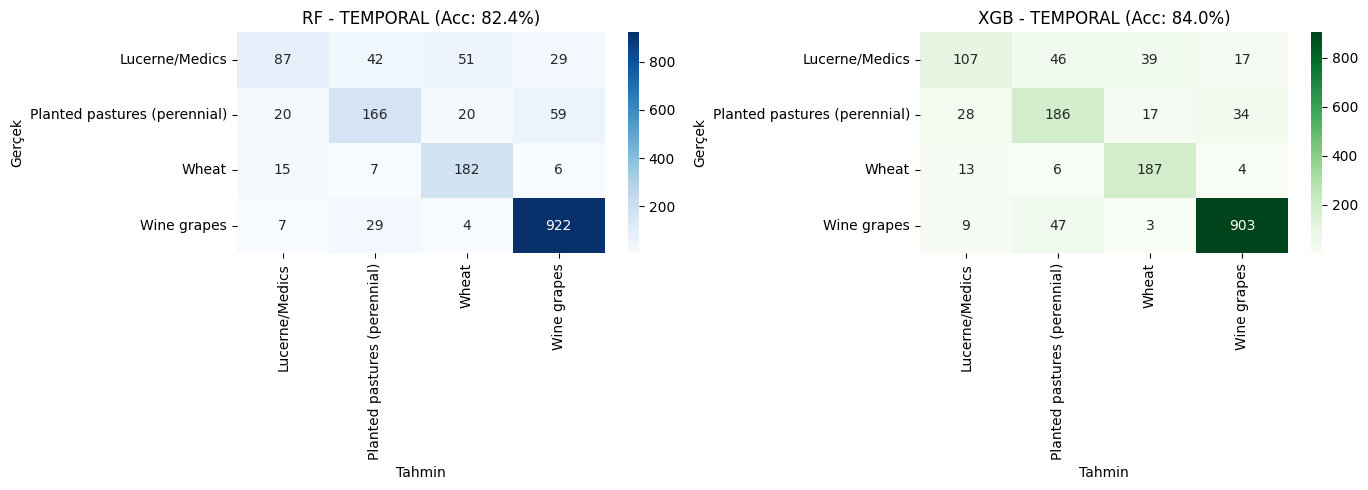

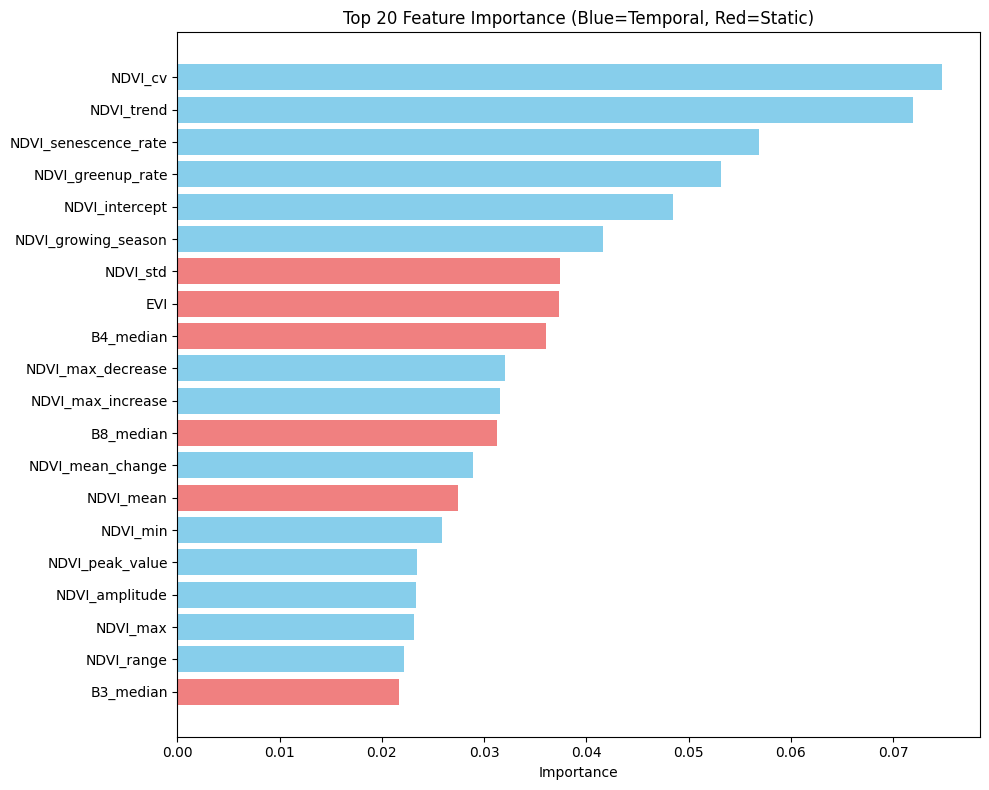


🌲 RF - Sınıf Bazında (TEMPORAL):
                              precision    recall  f1-score   support

              Lucerne/Medics       0.67      0.42      0.51       209
Planted pastures (perennial)       0.68      0.63      0.65       265
                       Wheat       0.71      0.87      0.78       210
                 Wine grapes       0.91      0.96      0.93       962

                    accuracy                           0.82      1646
                   macro avg       0.74      0.72      0.72      1646
                weighted avg       0.82      0.82      0.81      1646


🚀 XGB - Sınıf Bazında (TEMPORAL):
                              precision    recall  f1-score   support

              Lucerne/Medics       0.68      0.51      0.58       209
Planted pastures (perennial)       0.65      0.70      0.68       265
                       Wheat       0.76      0.89      0.82       210
                 Wine grapes       0.94      0.94      0.94       962

                

In [ ]:
# Confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_, ax=axes[0])
axes[0].set_title(f'RF - TEMPORAL (Acc: {rf_acc:.1%})')
axes[0].set_ylabel('Gerçek')
axes[0].set_xlabel('Tahmin')

cm_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Greens',
            xticklabels=le.classes_, yticklabels=le.classes_, ax=axes[1])
axes[1].set_title(f'XGB - TEMPORAL (Acc: {xgb_acc:.1%})')
axes[1].set_ylabel('Gerçek')
axes[1].set_xlabel('Tahmin')

plt.tight_layout()
plt.savefig(FIG_DIR / 'confusion_matrices_TEMPORAL.png', dpi=300)
plt.show()

# Feature importance plot
plt.figure(figsize=(10, 8))
top20 = feature_importance.head(20)
colors = ['skyblue' if f.startswith('NDVI_') and f not in ['NDVI_mean', 'NDVI_std'] else 'lightcoral'
          for f in top20['feature']]
plt.barh(range(len(top20)), top20['importance'], color=colors)
plt.yticks(range(len(top20)), top20['feature'])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importance (Blue=Temporal, Red=Static)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(FIG_DIR / 'feature_importance_TEMPORAL.png', dpi=300)
plt.show()

print("\n🌲 RF - Sınıf Bazında (TEMPORAL):")
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))

print("\n🚀 XGB - Sınıf Bazında (TEMPORAL):")
print(classification_report(y_test, y_pred_xgb, target_names=le.classes_))

print("\n💾 Tüm grafikler kaydedildi!")
print(f"⏰ Tamamlanma: {datetime.now().strftime('%H:%M:%S')}")